## Part-of-Speech tagging using CRF

# --------------------------------------------------------------------------------------------

# ******************* Syntactic Processing Assignment ********************************

### **********************    Part 2 - CRFs for POS Tagging **********************************************

### Author: Sushma KR ############
### Date: 27th July 2018

# --------------------------------------------------------------------------------------------

### Data Preparation

In [2]:
#Importing libraries
import re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random

import nltk
from nltk.tokenize import word_tokenize
nltk.download('brown')
nltk.download('conll2000')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

import calendar
from calendar import month_name, month_abbr
from calendar import day_name

import matplotlib.pyplot as plt

import _pickle as cPickle
import os.path

from collections import Counter

[nltk_data] Downloading package brown to /Users/raagzcd/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/raagzcd/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


In [3]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# first few tagged sentences
print(wsj[:2])
print(len(wsj))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]
3914


In [5]:
# reading the Brown tagged sentences
brown = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [6]:
# first few tagged sentences
print(brown[:2])
print(len(brown))

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [7]:
# reading the conll2000 tagged sentences
conll2000= list(nltk.corpus.conll2000.tagged_sents(tagset='universal'))

In [8]:
# first few tagged sentences
print(conll2000[:2])
print(len(conll2000))

[[('Confidence', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pound', 'NOUN'), ('is', 'VERB'), ('widely', 'ADV'), ('expected', 'VERB'), ('to', 'PRT'), ('take', 'VERB'), ('another', 'DET'), ('sharp', 'ADJ'), ('dive', 'NOUN'), ('if', 'ADP'), ('trade', 'NOUN'), ('figures', 'NOUN'), ('for', 'ADP'), ('September', 'NOUN'), (',', '.'), ('due', 'ADJ'), ('for', 'ADP'), ('release', 'NOUN'), ('tomorrow', 'NOUN'), (',', '.'), ('fail', 'VERB'), ('to', 'PRT'), ('show', 'VERB'), ('a', 'DET'), ('substantial', 'ADJ'), ('improvement', 'NOUN'), ('from', 'ADP'), ('July', 'NOUN'), ('and', 'CONJ'), ('August', 'NOUN'), ("'s", 'PRT'), ('near-record', 'ADJ'), ('deficits', 'NOUN'), ('.', '.')], [('Chancellor', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Exchequer', 'NOUN'), ('Nigel', 'NOUN'), ('Lawson', 'NOUN'), ("'s", 'PRT'), ('restated', 'VERB'), ('commitment', 'NOUN'), ('to', 'PRT'), ('a', 'DET'), ('firm', 'NOUN'), ('monetary', 'ADJ'), ('policy', 'NOUN'), ('has', 'VERB'), ('helped', 'VERB'), ('to', 'PRT'), ('prev

In [9]:
nltk_data = wsj + brown + conll2000

In [10]:
print(nltk_data[:2])
print(len(nltk_data))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]
72202


### 1. Build your CRF

##### Define feature functions that would enhance the maximum likelihood estimates

In [11]:
# Whether the word contains a hyphen or an apostrophe

def word_contains_char(word, char):
    if word.find(char) > 1:
        return True
    else:
        return False

In [12]:
#Check if the word is a month or an abbreviated version

months = set(m.lower() for m in month_name[1:])
months_abbr = set(m.lower() for m in month_abbr)

def word_is_a_month(word):

    word = word.lower()
    
    # If the word contains a hyphen or dot, extract the first part and check
    if word.find('.') > 0:
        word = word.split('.')[0].lower()
    if word.find('-') > 0:
        word = word.split('-')[0].lower()
    
    if word in months or word in months_abbr:
        return True
    else:
        return False

In [13]:
# Check if the word is a day of week

days = set(d.lower() for d in day_name[:])

def word_is_a_day(word):
    word = word.lower()
    
    if word in days:
        return True
    else:
        return False


In [14]:
# Import the countries file into a dataframe

countries = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

In [15]:
# Check if the given word is a country

def word_is_a_country(word):
    set(countries['name'].str.lower())
    
    if(word.lower() in set(countries['name'].str.lower())):
        return True
    else:
        return False

In [16]:
# Extract all the honorifics used in English into a dataframe

honorifics = pd.read_csv('https://gist.githubusercontent.com/abrambailey/9dbca470e9a562c625fd/raw/db0c0126301e6fd2a5b21a489f91a07d726fc893/EnglishHonorifics', quoting = 3)

In [17]:
honorifics = [re.sub("'", "", x).strip() for x in honorifics.index]

In [18]:
# Check if the word is a honorific such as Mr, Miss etc

def word_is_a_honorific(word):
    if word in honorifics or word[:-1] in honorifics:
        return True
    else:
        return False

In [19]:
# Extract city, state and county names in US to a dataframe

us_cities = pd.read_csv('https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv', sep = '|')
us_cities.head()

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [20]:
# storing cities, states and counties as sets

cities = set(us_cities['City'].str.lower())
states = set(us_cities['State full'].str.lower())
counties = set(us_cities['County'].str.lower())

In [21]:
# define a function to look up a given word in cities, states, county

def gazetteer_lookup(word):
    return (word in cities, word in states, word in counties)

In [22]:
# sample lookups

print(gazetteer_lookup('washington'))
print(gazetteer_lookup('utah'))
print(gazetteer_lookup('philadelphia'))

(True, True, True)
(False, True, True)
(True, False, True)


In [23]:
# extracts features for the word at index i in a sentence 

def word_features(sentence, i):
    word = sentence[i][0]
    
    # first word
    if i==0:
        prevword = '<START>'
    else:
        prevword = sentence[i-1][0]
    
    # last word
    if i == len(sentence)-1:
        nextword = '<END>'
    else:
        nextword = sentence[i+1][0]
        
    gazetteer = gazetteer_lookup(word)
    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    return {'word': word,
            'prevword': prevword,
            'nextword': nextword, 
            'word_is_digit': word.isdigit(),
            'wordlen': len(word),
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4,
            'initcap': word[0].isupper(),
            'prev_word_initcap': prevword[0].isupper(),
            'word_is_all_upper': word.isupper(),
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_an_adverb': word[-2:] == 'ly',
            'word_is_a_verb': word[-2:] == 'ly' or word[-3:] == 'ing'
#             'word_contains_apostrophe': word_contains_char(word,"'"),
#             'word_contains_hyphen': word_contains_char(word, '-'),
#             'word_contains_dot': word_contains_char(word, '.'),
#             'word_is_a_honorific': word_is_a_honorific(word),
#             'word_is_a_country': word_is_a_country(word),
#             'word_is_a_month': word_is_a_month(word),
#             'word_is_a_day': word_is_a_day(word)
           }  


In [24]:
# Extract the features of each word present in a sentence by the index position

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

In [25]:
# Capture the start time

In [26]:
start = time.time()

In [27]:
# This defines the input data set for the algorithm

wordfeatures = [sent2features(sent) for sent in nltk_data]

In [28]:
end = time.time()

In [29]:
print('Difference:', end - start)

Difference: 7.19297194480896


In [30]:
# This defines the output data set for the algorithm, will serve as the "y" that would be split into training and 
# test data sets

pos_tags = []
for sent in nltk_data:
    word_tags = []
    for tup in sent:
        word_tags.append(tup[1])
    pos_tags.append(word_tags)

In [31]:
# Split the input and output datasets into training and validation sets in the ratio of 80:20

X_train, X_valid, y_train, y_valid = train_test_split(wordfeatures, pos_tags, test_size=0.2, random_state=1)

In [32]:
len(X_train)

57761

In [33]:
len(X_valid)

14441

### 2. Evaluate the model performance

In [34]:
start = time.time()

In [35]:
# fitting crf with arbitrary hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.01, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [36]:
end = time.time()
difference = end-start
print(difference)

295.28702998161316


In [37]:
labels = crf.classes_

In [38]:
# Carry out prediction on the validation data set

y_pred_valid = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred_valid,
                      average='weighted', labels=labels)

0.973370197847479

### 3. Interpret the model (enlist important state and transition features)

In [39]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [40]:
print(metrics.flat_classification_report(
    y_valid, y_pred_valid, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000     38448
          X      0.985     0.877     0.927      1547
        ADJ      0.936     0.937     0.936     21769
        ADP      0.965     0.978     0.972     36894
        ADV      0.948     0.937     0.942     13950
       VERB      0.979     0.979     0.979     47138
        DET      0.979     0.984     0.981     34220
       CONJ      0.994     0.997     0.995      9512
       NOUN      0.977     0.978     0.977     77289
       PRON      0.973     0.948     0.960     11977
        PRT      0.909     0.887     0.898      8349
        NUM      0.986     0.994     0.990      5755

avg / total      0.973     0.973     0.973    306848



In [41]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [42]:
# instantiate a GridSearchCV object

rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=2,
                  scoring=f1_scorer, 
                  return_train_score=True)
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 80.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(flat_f1_score, average=weighted, labels=['DET', 'NOUN', 'ADP', 'VERB', 'ADJ', 'CONJ', '.', 'ADV', 'PRON', 'X', 'PRT', 'NUM']),
       verbose=1)

In [43]:
# store CV results in a DF

cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c1,param_c2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,214.308638,14.619042,6.956551,0.134989,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",0.969142,0.969877,0.969856,0.969625,0.000342,6,0.991512,0.991238,0.991409,0.991386,0.000113
1,210.055309,9.569213,6.676993,0.048521,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",0.970869,0.971696,0.971544,0.971370,0.000359,2,0.989260,0.989049,0.989157,0.989155,0.000086
2,242.815552,49.669689,7.257208,0.499369,0.01,1,"{'c1': 0.01, 'c2': 1}",0.969269,0.970092,0.969692,0.969684,0.000336,5,0.978404,0.978165,0.977970,0.978180,0.000178
3,337.076049,11.370304,11.587638,4.175477,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",0.970350,0.971016,0.971125,0.970830,0.000343,3,0.990917,0.990749,0.990887,0.990851,0.000073
4,338.871480,9.996433,12.513003,7.735089,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",0.971052,0.971855,0.971472,0.971460,0.000328,1,0.988392,0.988122,0.988243,0.988252,0.000110
5,335.634802,6.478181,9.323682,0.703183,0.1,1,"{'c1': 0.1, 'c2': 1}",0.969064,0.969818,0.969484,0.969455,0.000308,8,0.977697,0.977437,0.977210,0.977448,0.000199
6,321.398272,14.214177,18.460877,9.044935,1,0.01,"{'c1': 1, 'c2': 0.01}",0.969408,0.970052,0.970024,0.969828,0.000297,4,0.976835,0.976506,0.976392,0.976577,0.000188
7,368.163482,11.260370,18.126002,9.099577,1,0.1,"{'c1': 1, 'c2': 0.1}",0.969217,0.969923,0.969648,0.969596,0.000291,7,0.975913,0.975610,0.975464,0.975662,0.000187
8,320.238645,24.854551,10.692754,6.303131,1,1,"{'c1': 1, 'c2': 1}",0.966881,0.967588,0.967242,0.967237,0.000288,9,0.971810,0.971271,0.971252,0.971444,0.000259


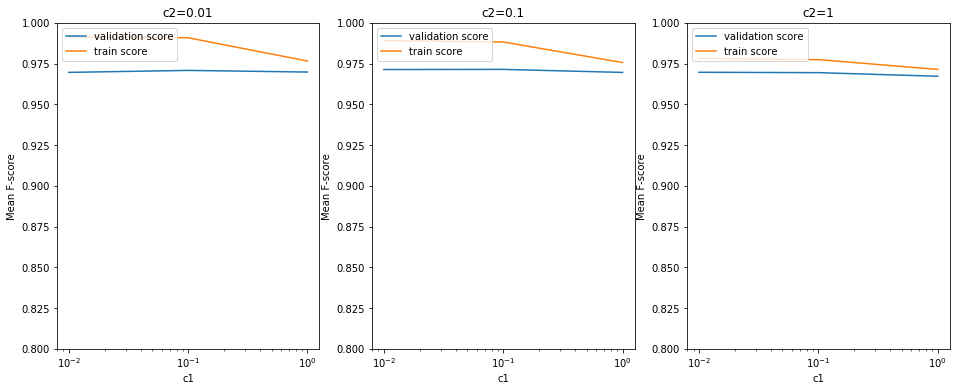

In [44]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and test f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.80, 1])
    plt.legend(['validation score', 'train score'], loc='upper left')
    plt.xscale('log')
    
plt.show()    

In [45]:
# building a model with optimal hyperparams

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [46]:
# save the model to a pickle file

# if os.path.exists('SushmaKR_part2.pkl') == False:
with open('SushmaKR_part2.pkl', 'wb') as clf:
    try:
        cPickle.dump(crf, clf)
    except Exception as e:
        print(e)
    finally:
        clf.close()  

In [47]:
# load the trained model

with open('SushmaKR_part2.pkl', 'rb') as fid:
    crf = cPickle.load(fid)

# Making Predictions - Validation Data Set

In [48]:
# remove 'O' from the labels
labels =list(crf.classes_)

# make predictions on validation data
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

0.9732008567229816

In [49]:
# class-wise scores on validation data
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000     38448
          X      0.983     0.878     0.928      1547
        ADJ      0.936     0.935     0.935     21769
        ADP      0.965     0.978     0.972     36894
        ADV      0.947     0.938     0.943     13950
       VERB      0.979     0.979     0.979     47138
        DET      0.979     0.983     0.981     34220
       CONJ      0.994     0.997     0.996      9512
       NOUN      0.976     0.978     0.977     77289
       PRON      0.973     0.948     0.960     11977
        PRT      0.907     0.888     0.897      8349
        NUM      0.987     0.994     0.990      5755

avg / total      0.973     0.973     0.973    306848



# Making predictions - Test Data Set

In [50]:
# We noticed that while using Viterbi algorithm, a number of words got tagged incorrectly and accuracy was relatively 
# low. CRF has done a much better job at predicting the POS tags of words such as Show, Android that turned out to be
# unknown for the Viterbi algorithm

Test_sentences= []
Test_sentences.append('Show me flights from Denver to Nebraska departing after 8 p.m.')
Test_sentences.append('Android is a mobile operating system developed by Google based on a modified version of the Linux kernel.')

In [51]:
# Below lines of code modify the above sentences in a format that the CRF algorithm can easily work with.
# POS tag is hardcoded, which will be replaced by the actual POS tag following the prediction

Test_sentences_mod = []
for sent in Test_sentences:
    new_list = []
    for word in word_tokenize(sent):
        tup = tuple()
        tup = (word, 'POS')
        new_list.append(tup)
    Test_sentences_mod.append(new_list) 


In [52]:
# Invoke the word features function to generate the input test dataset

X_test = [sent2features(sent) for sent in Test_sentences_mod]

In [53]:
X_test

[[{'word': 'Show',
   'prevword': '<START>',
   'nextword': 'me',
   'word_is_digit': False,
   'wordlen': 4,
   'suff_1': 'w',
   'suff_2': 'ow',
   'suff_3': 'how',
   'suff_4': 'Show',
   'pref_1': 'S',
   'pref_2': 'Sh',
   'pref_3': 'Sho',
   'pref_4': 'Show',
   'initcap': True,
   'prev_word_initcap': False,
   'word_is_all_upper': False,
   'word_is_city': False,
   'word_is_state': False,
   'word_is_county': False,
   'word_is_an_adverb': False,
   'word_is_a_verb': False},
  {'word': 'me',
   'prevword': 'Show',
   'nextword': 'flights',
   'word_is_digit': False,
   'wordlen': 2,
   'suff_1': 'e',
   'suff_2': 'me',
   'suff_3': 'me',
   'suff_4': 'me',
   'pref_1': 'm',
   'pref_2': 'me',
   'pref_3': 'me',
   'pref_4': 'me',
   'initcap': False,
   'prev_word_initcap': True,
   'word_is_all_upper': False,
   'word_is_city': False,
   'word_is_state': False,
   'word_is_county': False,
   'word_is_an_adverb': False,
   'word_is_a_verb': False},
  {'word': 'flights',
   'pr

In [54]:
# Carry out the prediction to determine the POS tags
y_pred_test = crf.predict(X_test)

In [55]:
# Following lines of code show the data in a user friendly manner as a list of tuples containing pairs of word and POS tag

y_result = []
for i, sent in enumerate(Test_sentences_mod):
    y_sent = []
    for j, tup in enumerate(sent):
        y_sent.append((tup[0], y_pred_test[i][j]))
    y_result.append(y_sent)
    
print(y_result)

[[('Show', 'VERB'), ('me', 'PRON'), ('flights', 'NOUN'), ('from', 'ADP'), ('Denver', 'NOUN'), ('to', 'ADP'), ('Nebraska', 'NOUN'), ('departing', 'VERB'), ('after', 'ADP'), ('8', 'NUM'), ('p.m', 'ADV'), ('.', '.')], [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'VERB'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('based', 'VERB'), ('on', 'ADP'), ('a', 'DET'), ('modified', 'VERB'), ('version', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Linux', 'NOUN'), ('kernel', 'NOUN'), ('.', '.')]]


In [56]:
# Few more sentences for testing

Test_sentences = []
Test_sentences.append('Android is a mobile operating system developed by Google.')
Test_sentences.append('Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.')
Test_sentences.append("Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.")
Test_sentences.append('Twitter is an online news and social networking service on which users post and interact with messages known as tweets.')
Test_sentences.append('Before entering politics, Donald Trump was a domineering businessman and a television personality.')
Test_sentences.append('The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.')
Test_sentences.append('This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.')
Test_sentences.append('Show me the cheapest round trips from Dallas to Atlanta')
Test_sentences.append('I would like to see flights from Denver to Philadelphia.')
Test_sentences.append('Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.')
Test_sentences.append('NASA invited social media users to experience the launch of ICESAT-2 Satellite.')

In [57]:
# Convert the sentences in a format that the algorithm can easily work with
# "POS" is hardcoded, which we expect to be replaced the accurate POS tag following the prediction

Test_sentences_mod = []
for sent in Test_sentences:
    new_list = []
    for word in word_tokenize(sent):
        tup = tuple()
        tup = (word, 'POS')
        new_list.append(tup)
    Test_sentences_mod.append(new_list) 
print(Test_sentences_mod)

[[('Android', 'POS'), ('is', 'POS'), ('a', 'POS'), ('mobile', 'POS'), ('operating', 'POS'), ('system', 'POS'), ('developed', 'POS'), ('by', 'POS'), ('Google', 'POS'), ('.', 'POS')], [('Android', 'POS'), ('has', 'POS'), ('been', 'POS'), ('the', 'POS'), ('best-selling', 'POS'), ('OS', 'POS'), ('worldwide', 'POS'), ('on', 'POS'), ('smartphones', 'POS'), ('since', 'POS'), ('2011', 'POS'), ('and', 'POS'), ('on', 'POS'), ('tablets', 'POS'), ('since', 'POS'), ('2013', 'POS'), ('.', 'POS')], [('Google', 'POS'), ('and', 'POS'), ('Twitter', 'POS'), ('made', 'POS'), ('a', 'POS'), ('deal', 'POS'), ('in', 'POS'), ('2015', 'POS'), ('that', 'POS'), ('gave', 'POS'), ('Google', 'POS'), ('access', 'POS'), ('to', 'POS'), ('Twitter', 'POS'), ("'s", 'POS'), ('firehose', 'POS'), ('.', 'POS')], [('Twitter', 'POS'), ('is', 'POS'), ('an', 'POS'), ('online', 'POS'), ('news', 'POS'), ('and', 'POS'), ('social', 'POS'), ('networking', 'POS'), ('service', 'POS'), ('on', 'POS'), ('which', 'POS'), ('users', 'POS'), (

In [58]:
# Generate the X_test using the word features function

X_test = [sent2features(sent) for sent in Test_sentences_mod]

In [59]:
# Carry out the prediction
y_pred_test = crf.predict(X_test)


In [60]:
# Presenting the prediction results in tuple containing pairs of word and actual POS tag assigned through prediction

y_result = []
for i, sent in enumerate(Test_sentences_mod):
    y_sent = []
    for j, tup in enumerate(sent):
        y_sent.append((tup[0], y_pred_test[i][j]))
    y_result.append(y_sent)
    
print(y_result)

[[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'VERB'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')], [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')], [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')], [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET

#### Understanding the CRF Classifier

In [61]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
X      -> X       5.005582
.      -> .       2.063977
PRT    -> VERB    1.680046
PRON   -> VERB    1.615458
ADP    -> DET     1.294666
DET    -> NOUN    1.284739
NOUN   -> .       1.238129
NOUN   -> PRON    1.119275
VERB   -> PRT     1.054905
ADJ    -> NOUN    1.016501
DET    -> VERB    0.993141
DET    -> ADJ     0.832283
NOUN   -> ADP     0.772690
DET    -> X       0.698540
VERB   -> ADP     0.679546
PRT    -> ADP     0.663284
VERB   -> DET     0.630733
PRT    -> .       0.600684
ADV    -> ADJ     0.568077
NOUN   -> VERB    0.553172

Top unlikely transitions:
ADP    -> VERB    -1.358400
NOUN   -> ADJ     -1.387804
ADJ    -> ADV     -1.455003
DET    -> PRT     -1.603118
NUM    -> X       -1.616887
NUM    -> ADV     -1.631685
NUM    -> PRON    -1.642219
X      -> ADV     -1.777474
ADJ    -> PRON    -1.809385
CONJ   -> CONJ    -1.823770
ADV    -> X       -1.845694
X      -> NOUN    -1.910355
CONJ   -> .       -1.944773
ADJ    -> VERB    -2.048171
X      -> NUM    

In [62]:
# important features

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
9.457535 ADJ      word:willing
8.524048 NOUN     word:something
8.286730 PRT      suff_2:'d
7.963383 NOUN     suff_1:%
7.674522 ADJ      word:interesting
7.659134 NOUN     word:thing
7.626072 .        suff_1:$
7.175610 ADJ      word:lovely
7.049217 VERB     suff_4:tood
6.966675 VERB     word:consists
6.955069 ADV      suff_4:wise
6.903264 ADJ      word:other
6.877046 VERB     prevword:may
6.853703 X        pref_1:*
6.851860 NOUN     pref_1:$
6.810270 DET      pref_4:whic
6.783043 VERB     prevword:didn't
6.770811 ADJ      word:charming
6.615900 VERB     prevword:could
6.541142 NOUN     word:ally
6.541142 NOUN     pref_4:ally
6.451589 ADJ      word:aware
6.430631 VERB     prevword:won't
6.348302 PRON     nextword:'s
6.345271 PRT      suff_2:'s
6.319232 VERB     prevword:wouldn't
6.272716 ADJ      word:certain
6.238290 DET      word:every
6.219733 DET      nextword:'s
6.129581 NOUN     word:year

Top negative:
-3.686241 VERB     pref_2:it
-3.695251 .        prevword:Critica